# Connectomes Data and Modeling Techniques

### Techniques covered in this Notebook
- Preprocessing the functional connectome data
- Convolutional neural networks

V2
- Higher weight for females in loss function
- Added F1 score to metrics
- Optimised threshold

## Functional Connectomes

A **functional connectome** refers to the theoretical concept of the brain's functional connections, which describes how different brain regions interact and communicate with each other.

**Functional connectome data**, on the other hand, is the actual data that represents these connections, typically obtained through neuroimaging techniques such as functional MRI. This data provides a quantitative measure of the synchronized activity between brain regions, allowing researchers to study and analyze the functional connectome.

This data is crucial in ADHD research, as it can help us understand how brain connectivity patterns differ between individuals with ADHD and those without. By analyzing these patterns, we can identify potential biomarkers for ADHD and develop more accurate diagnostic tools.


## The 2025 Datathon Functional Connectome Data

The dataset correponds to the Functional Connectivity Networks (FCN) extracted from resting-state fMRIs of **1213 patients at 200 Regions Of Interest (ROIs)**. Patients are separated in two classes: ADHD and control. The goal will be to classify them. (You can also use these techniques to classify the sex of the patients.)







## Geodesic vs Euclidean Distances

We compare brain connectomes using Symmetric Positive Definite (SPD) matrices, which live on a curved surface (a manifold). To calculate distances between them, we use geodesic distance (shortest path on the curve, shown in black) instead of Euclidean distance (straight-line distance, shown in red).

## Functional Connectome Data and SPD Matrices

Functional connectome data is often approximated as a Symmetric Positive Definite (SPD) matrix. However, in reality, functional connectome data may not always be perfectly SPD.

# Load the data

In [1]:
!pip install geomstats
!pip install tensorflow==2.15.0
!pip install tensorflow-addons==0.23.0

In [ ]:
# Mount Google Drive (if run on Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import csv
import openpyxl
import matplotlib.pyplot as plt
import time

import geomstats.datasets.utils as data_utils
import geomstats.backend as gs
from geomstats.geometry.skew_symmetric_matrices import SkewSymmetricMatrices

# Read in the data (update to your root folder)
start_time = time.time()

# Read in the data (update to your root folder)
df_soln = pd.read_excel("/content/drive/MyDrive/WIDS_2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
df_conn = pd.read_csv("/content/drive/MyDrive/WIDS_2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
df_conn_test = pd.read_csv("/content/drive/MyDrive/WIDS_2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

# Extract the ADHD solutions and sort the data by participant_id
df_soln_adhd = df_soln[['participant_id', 'ADHD_Outcome']].sort_values('participant_id')
df_conn = df_conn.sort_values('participant_id')

### Reshape the connectome data into symmetric matrices

We are given the upper half of the connectome matrices as vectors, which represent the functional connections between different brain regions. However, to analyze and process this data using Riemannian geometry-based methods, we need to reshape it into symmetric matrices.

By reshaping the upper half vectors into symmetric matrices, we can reconstruct the full matrix, which is a more natural representation of the brain's functional connectivity.

In [4]:
# Define the load_connectomes function
def load_connectomes(df_conn, df_soln_adhd, as_vectors=False):
    """
    Load brain connectome data and ADHD labels, returning symmetric matrices with ones on the diagonal.
    """

    patient_id = gs.array(df_conn['participant_id'])
    data = gs.array(df_conn.drop('participant_id', axis=1))
    target = gs.array(df_soln_adhd['ADHD_Outcome'])

    if as_vectors:
        return data, patient_id, target
    mat = SkewSymmetricMatrices(200).matrix_representation(data)
    mat = gs.eye(200) - gs.transpose(gs.tril(mat), (0, 2, 1))
    mat = 1.0 / 2.0 * (mat + gs.transpose(mat, (0, 2, 1)))

    return mat, patient_id, target

In [5]:
# Call the load_connectomes function
data, patient_id, labels = load_connectomes(df_conn, df_soln_adhd)

# Print the results
print(f"There are {len(data)} connectomes: {sum(labels==0)} non-ADHD and {sum(labels==1)} ADHD patients.")

There are 1213 connectomes: 382 non-ADHD and 831 ADHD patients.


In [6]:
data.shape

(1213, 200, 200)

We now have 200 x 200 matrices for each of the 1213 patients

# Convolutional Neural Networks

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

### Data Preparation

We need to convert our data into a format that can be used by the CNN. This involves creating graph data objects for each connectivity matrix.

In [8]:
# Convert the data to a NumPy array first, and add a new axis for CNN input
data = np.array(data)  # Ensure it's a NumPy array
data = data[..., np.newaxis]  # Add the channel dimension (e.g., shape: [1213, 200, 200, 1])

# Keep target labels as a NumPy array
target = np.array(labels, dtype=np.float32) # Changed to keep target as NumPy array

In [9]:
### Splitting Data into Training and Testing Sets

In [10]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42)

### Defining the CNN

- 1 Conv2D Layer
- BatchNorm + ReLU
- Flatten
- Dense → BatchNorm → ReLU → Dropout (50%) (repeated 3 times)

In [11]:
# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Flatten(),

    layers.Dense(256),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.5),

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.5),

    layers.Dense(64),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')  # Binary classification
])

Compile model

In [12]:
import tensorflow_addons as tfa

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
              tfa.metrics.F1Score(num_classes=1, average='macro', threshold=0.5),
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall()]
              )

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Train the model

Train the model using a simple training loop.

In [13]:
class_weight = {
    0: 1.0,  # males
    1: 2.0   # females
}

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=30, batch_size=32, class_weight=class_weight)

Epoch 1/30
31/31 [==============================] - 239s 7s/step - loss: 1.4795 - accuracy: 0.5165 - f1_score: 0.6108 - precision: 0.6904 - recall: 0.5476 - val_loss: 0.6535 - val_accuracy: 0.6543 - val_f1_score: 0.7910 - val_precision: 0.6543 - val_recall: 1.0000
Epoch 2/30
31/31 [==============================] - 220s 7s/step - loss: 0.9959 - accuracy: 0.6443 - f1_score: 0.7572 - precision: 0.7183 - recall: 0.8006 - val_loss: 0.6441 - val_accuracy: 0.6543 - val_f1_score: 0.7910 - val_precision: 0.6543 - val_recall: 1.0000
Epoch 3/30
31/31 [==============================] - 226s 7s/step - loss: 1.0184 - accuracy: 0.6474 - f1_score: 0.7738 - precision: 0.6964 - recall: 0.8705 - val_loss: 0.6434 - val_accuracy: 0.6543 - val_f1_score: 0.7910 - val_precision: 0.6543 - val_recall: 1.0000
Epoch 4/30
31/31 [==============================] - 227s 7s/step - loss: 0.9117 - accuracy: 0.6773 - f1_score: 0.7977 - precision: 0.7051 - recall: 0.9182 - val_loss: 0.6430 - val_accuracy: 0.6543 - val_f1

### Evaluate the model

Evaluate the model on the test set and calculate its accuracy.

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Get model predictions (returns probabilities)
y_pred_probs = model.predict(X_val)
best_f1, best_thresh = 0, 0.5

for thresh in np.linspace(0.1, 0.9, 81):
    y_pred = (y_pred_probs > thresh).astype(int)
    f1 = f1_score(y_val, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best F1 = {best_f1:.4f} at threshold = {best_thresh:.2f}")

# Convert y_val to numpy (if it's still a Tensor)
y_true = y_val.numpy() if hasattr(y_val, 'numpy') else y_val

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_probs)

# Display results
print(f"Number of examples in test data: {len(y_true)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

8/8 [==============================] - 8s 1s/step
Best F1 = 0.7809 at threshold = 0.11
Number of examples in test data: 243
Accuracy: 0.6008
ROC AUC: 0.5021


### Training Loss Plot

Visualize the training loss over epochs to see how the model converges.

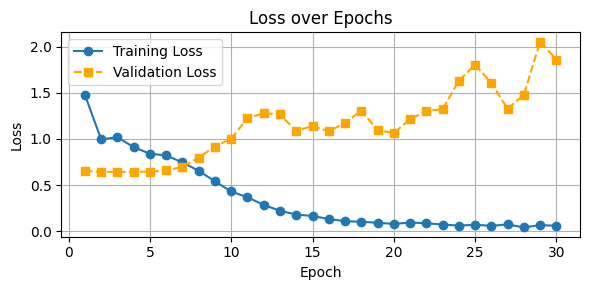

In [16]:
import matplotlib.pyplot as plt

# Access loss history
losses = history.history['loss']
val_losses = history.history['val_loss']
epochs = list(range(1, len(losses) + 1))

# Plot the losses
plt.figure(figsize=(6, 3))
plt.plot(epochs, losses, marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs, val_losses, marker='s', linestyle='--', label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion Matrix

To evaluate the model's performance

8/8 [==============================] - 8s 1s/step


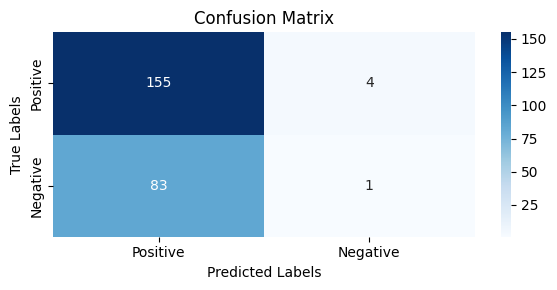

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_true and y_pred are NumPy arrays
y_true = y_val.numpy() if hasattr(y_val, 'numpy') else y_val
y_pred = (model.predict(X_val) > best_thresh).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: [TP, FN], [FP, TN] format
# If you want to follow your previous manual format:
conf_matrix = np.array([[cm[1,1], cm[1,0]],
                        [cm[0,1], cm[0,0]]])

# Plot
cm_labels = ['Positive', 'Negative']
categories = ['Positive', 'Negative']

plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=categories)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Use predicted labels from model
y_true = y_val.numpy() if hasattr(y_val, 'numpy') else y_val
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > best_thresh).astype(int)

# Flatten if needed
y_true = np.ravel(y_true)
y_pred = np.ravel(y_pred)

# Metrics
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Output
print("F1 score:", round(f1, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("Accuracy:", round(accuracy, 4))


8/8 [==============================] - 6s 744ms/step
F1 score: 0.7809
Precision: 0.6513
Recall: 0.9748
Accuracy: 0.642


Convert patient_id to a 1D numpy array:

In [19]:
patient_id_np = np.array(patient_id)

In [20]:
y_pred_train_probs = model.predict(data)


38/38 [==============================] - 34s 893ms/step


In [21]:
y_pred_train = (y_pred_train_probs > best_thresh).astype(int)

Include ADHD predictins and probabilities on the trainig dataset in a pandas dataframe and save to a csv file.

In [22]:
train_pred_prob_df = pd.DataFrame({
    'participant_id': patient_id_np,  # This should be your patient_id array
    'predicted_label': y_pred_train.flatten(),  # Flatten the predictions (if needed)
    'probability': y_pred_train_probs.flatten()  # Flatten the probabilities (if needed)
})

# Save to CSV
train_pred_prob_df.to_csv("/content/drive/MyDrive/WIDS_2025/Output/cnn_train_pred_prob_adhd.csv", index=False)

## Prediction on the test set

In [23]:
def load_connectomes_test(df_conn):

    """
    Load brain connectome data, returning symmetric matrices with ones on the diagonal.
    """

    patient_id = gs.array(df_conn['participant_id'])
    data = gs.array(df_conn.drop('participant_id', axis=1))

    mat = SkewSymmetricMatrices(200).matrix_representation(data)
    mat = gs.eye(200) - gs.transpose(gs.tril(mat), (0, 2, 1))
    mat = 1.0 / 2.0 * (mat + gs.transpose(mat, (0, 2, 1)))

    return mat, patient_id

In [24]:
data_test, patient_id_test = load_connectomes_test(df_conn_test)

In [25]:
data_test.shape

(304, 200, 200)

Reformat data for CNN:

In [26]:
# Convert the data to a NumPy array first, and add a new axis for CNN input
data_test = np.array(data_test)  # Ensure it's a NumPy array
data_test = data_test[..., np.newaxis]

In [27]:
# Assuming data_test is the test data
# Make predictions on the test data
y_pred_probs_test = model.predict(data_test)

# Convert probabilities to binary predictions (thresholded at best_thresh)
y_pred_test = (y_pred_probs_test > best_thresh).astype(int)

# Store the predictions and probabilities
predicted_labels_test = y_pred_test.flatten()
probabilities_test = y_pred_probs_test.flatten()

# Print or save predictions to a DataFrame or file
import pandas as pd
test_pred_prob_df = pd.DataFrame({
    'participant_id': patient_id_test,  # Assuming patient_id_test is the corresponding ID for test data
    'predicted_label': predicted_labels_test,
    'probability': probabilities_test
})

test_pred_prob_df.to_csv("/content/drive/MyDrive/WIDS_2025/Output/cnn_test_pred_prob_adhd.csv", index=False)

print("Predictions and probabilities saved.")


10/10 [==============================] - 10s 968ms/step
Predictions and probabilities saved.


Include ADHD preditions on the test dataset to a pandas dataframe and save to a submission csv file.

In [28]:
submission_cnn_adhd = pd.DataFrame({
    'participant_id': patient_id_test,  # Updated to correct test dataset patient IDs
    'predicted_label': predicted_labels_test
})

# Save to CSV
submission_cnn_adhd.to_csv("/content/drive/MyDrive/WIDS_2025/Output/submission_cnn_adhd.csv", index=False)


In [29]:
# Print runtime
end_time = time.time()
runtime = round((end_time - start_time)/60, 1)
print('Total runtime of CNN ADHD prediction is ', runtime, 'minutes')

Total runtime of CNN ADHD prediction is  133.2 minutes
